In [1]:
from symfit import parameters, variables, sin, cos, Fit
from scipy import optimize
import tabulate as tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cmath

def Rabc(alfal, betal, gamal): #Euler Rotation Matrix
    U = np.zeros((3, 3))
    U[0, 0] = np.cos(alfal)*np.cos(betal)*np.cos(gamal) - np.sin(alfal)*np.sin(gamal)
    U[0, 1] = np.sin(alfal)*np.cos(betal)*np.cos(gamal) + np.cos(alfal)*np.sin(gamal)
    U[0, 2] = -np.sin(betal)*np.cos(gamal)
    U[1, 0] = -np.cos(alfal)*np.cos(betal)*np.sin(gamal) - np.sin(alfal)*np.cos(gamal)
    U[1, 1] = -np.sin(alfal)*np.cos(betal)*np.sin(gamal) + np.cos(alfal)*np.cos(gamal)
    U[1, 2] = np.sin(betal)*np.sin(gamal)
    U[2, 0] = np.cos(alfal)*np.sin(betal)
    U[2, 1] = np.sin(alfal)*np.sin(betal)
    U[2, 2] = np.cos(betal)
    return U

def Quad(QXG, ct, st, s2t, c2t, cp, sp, c2p, s2p): #Quadrupolar Interaction Function
    sq15 = np.sqrt(1.5)
    sq6 = np.sqrt(6)
    R20Q = 0.5*sq15*(QXG[2,2]*(3*ct*ct-1)+2*QXG[0,2]*s2t*cp+2*QXG[1,2]*s2t*sp+(QXG[0,0]-QXG[1,1])*st*st*c2p+2*QXG[0,1]*st*st*s2p)
    R2q1 = 0.75*QXG[2,2]*s2t
    R2q2r = QXG[0,2]*c2t*cp
    R2q2i = QXG[0,2]*ct*sp
    R2q3r = QXG[1,2]*c2t*sp
    R2q3i = QXG[1,2]*ct*cp
    R2q4r = 0.25*(QXG[0,0]-QXG[1,1])*s2t*c2p
    R2q4i = 0.5*(QXG[0,0]-QXG[1,1])*st*s2p
    R2q5r = 0.5*QXG[0,1]*s2t*s2p
    R2q5i = QXG[0,1]*st*c2p
    R2p1Q = R2q1 - R2q2r + 1j*R2q2i - R2q3r - 1j*R2q3i - R2q4r + 1j*R2q4i - R2q5r - 1j*R2q5i
    R2m1Q=-R2q1+R2q2r+1j*R2q2i+R2q3r-1j*R2q3i+R2q4r+1j*R2q4i+R2q5r-1j*R2q5i;
  
    R4q1=0.75*QXG[2,2]*st*st;
    R4q2r=0.5*QXG[0,2]*s2t*cp; R4q2i=QXG[0,2]*st*sp;
    R4q3r=0.5*QXG[1,2]*s2t*sp; R4q3i=QXG[1,2]*st*cp;
    R4q4r=0.25*(QXG[0,0]-QXG[1,1])*(1+ct*ct)*c2p; R4q4i=0.5*(QXG[0,0]-QXG[1,1])*ct*s2p;
    R4q5r=0.5*QXG[0,1]*(1+ct*ct)*s2p; R4q5i=QXG[0,1]*ct*c2p;
    R2p2Q=R4q1-R4q2r+1j*R4q2i-R4q3r-1j*R4q3i+R4q4r-1j*R4q4i+R4q5r+1j*R4q5i;
    R2m2Q=R4q1-R4q2r-1j*R4q2i-R4q3r+1j*R4q3i+R4q4r+1j*R4q4i+R4q5r-1j*R4q5i;
    # return [R2m1Q,R2p1Q,R20Q,R2m2Q, R2p2Q]
    return [R2m2Q, R2m1Q, R20Q, R2p1Q, R2p2Q]
    

def ChemShift(CsaQXG, ct, st, s2t, c2t, cp, sp, c2p, s2p):
    sq15 = np.sqrt(1.5)
    R20cs = 0.5 * sq15 * ((2 * CsaQXG[2, 2] - CsaQXG[0, 0] - CsaQXG[1, 1]) * (ct ** 2 - 1/3) +2 * CsaQXG[0, 2] * s2t * cp + 2 * CsaQXG[1, 2] * s2t * sp +(CsaQXG[0, 0] - CsaQXG[1, 1]) * st ** 2 * c2p + 2 * CsaQXG[0, 1] * st ** 2 * s2p)
    R2cs0 = 0.25 * (2 * CsaQXG[2, 2] - CsaQXG[0, 0] - CsaQXG[1, 1]) * s2t
    R2cs1r = CsaQXG[0, 2] * c2t * cp
    R2cs1i = CsaQXG[0, 2] * ct * sp
    R2cs2r = CsaQXG[1, 2] * c2t * sp
    R2cs2i = CsaQXG[1, 2] * ct * cp
    R2cs3r = 0.25 * (CsaQXG[0, 0] - CsaQXG[1, 1]) * s2t * c2p
    R2cs3i = 0.5 * (CsaQXG[0, 0] - CsaQXG[1, 1]) * st * s2p
    R2cs4r = 0.5 * CsaQXG[0, 1] * s2t * s2p
    R2cs4i = CsaQXG[0, 1] * st * c2p
    R2p1cs = R2cs0 - R2cs1r + 1j * R2cs1i - R2cs2r - 1j * R2cs2i - R2cs3r + 1j * R2cs3i - R2cs4r - 1j * R2cs4i
    R2m1cs = -R2cs0 + R2cs1r + 1j * R2cs1i + R2cs2r - 1j * R2cs2i + R2cs3r + 1j * R2cs3i + R2cs4r - 1j * R2cs4i
    # return [R20cs, R2p1cs, R2m1cs]
    return [R2m1cs, R20cs, R2p1cs]

def AntiShift(AcsQXG, ct, st, cp, sp):
    R11 = 0.5*(AcsQXG[0,1]-AcsQXG[1,0])*st
    R12 = 0.5*(AcsQXG[0,2]-AcsQXG[2,0])*cp
    R13 = 0.5*(AcsQXG[0,2]-AcsQXG[2,0])*ct*sp
    R14 = 0.5*(AcsQXG[1,2]-AcsQXG[2,1])*sp
    R15 = 0.5*(AcsQXG[1,2]-AcsQXG[2,1])*ct*cp
    R1p1acs = -1j*R11 + R12 - 1j*R13 + R14 + 1j*R15
    R1m1acs = 1j*R11 + R12 + 1j*R13 + R14 - 1j*R15
    # return [R1p1acs, R1m1acs]
    return[R1m1acs, R1p1acs]

Nptx = 500
freq1D = np.zeros((Nptx+1,1))
freq2D = np.zeros((Nptx+1,1))
freqSUM = np.zeros((Nptx+1,1))
XX = np.zeros((Nptx+1,1))
freqDIFF = np.zeros((Nptx+1,1))
qacs = np.zeros((Nptx+1,1))
qcsa = np.zeros((Nptx+1,1))
# name = input('Enter Name of File:')
# w0 = float(input('Enter Larmor Frequency for nuclei in MHz:')) #Larmor fre in MHz #for N14
w0 = 43.4 #input for 14N
# print(w0)
wX = w0*10**6 #actual freq in Hz

ntheta  = 500
nphi = 500

dangle  = 2*np.pi/Nptx

#Spin Quantum Number
Ispin = 1.

#Quadrupolar Coupling Tensor
#coupling values for NAV (taken from paper https://pubmed.ncbi.nlm.nih.gov/22027340/)

CQ_M = -3.03 #CQ in MHz
# CQ = 0
Qeta = 0.45 #eta of Q

# Symmetric 2nd-rank chemical shift anisotropy (CSA)   tensor
Siso_ppm = 0.     #isotropic chemical shift + offset(ppm)
delta_ppm = 110  #chemical shift anisotropy (CSA) (ppm)
eta = 0.415   #eta of CSA

# CQ_M = -3.21 #CQ in MHz
# # CQ = 0
# Qeta = 0.32 #eta of Q

# # Symmetric 2nd-rank chemical shift anisotropy (CSA)   tensor
# Siso_ppm = 0.     #isotropic chemical shift + offset(ppm)
# delta_ppm = 110.  #chemical shift anisotropy (CSA) (ppm)
# eta = 0.415   #eta of CSA

# Antisymmetric 1st-rank chemical shift (ACS) tensor
Sxy = 50; Sxz = 50; Syz = 50

CQ = CQ_M*10**6/(2*Ispin*(2*Ispin-1))
# Sxy = Sxy*w0; Sxz = Sxz*w0; Syz = Syz*w0;
Siso = Siso_ppm*w0
delta = delta_ppm*w0
Sxy = Sxy*w0; Sxz = Sxz*w0; Syz = Syz*w0;

# Siso = Siso_ppm*wX
# delta = delta_ppm*wX

# CQ = CQ_M*10**6/(2*Ispin*(2*Ispin-1))
# Sxy = Sxy*wX; Sxz = Sxz*wX; Syz = Syz*wX;

#*****Relative Tensor Orientations
#input parameters
#       {a,b,c)       {zeta,lamda,nu}         {alpha,beta,gama}           {phi,theta, 0}
# CSA===========>Quad==================>X-tal=======================>Gon=================>Lab

a, b, c = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180
zeta, lamda, nu = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180
alpha, beta, gama = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180

# tensor parameter at PAS
QPAS = np.zeros((3, 3))
Csa = np.zeros((3, 3))
Acs = np.zeros((3, 3))

#Quadrupolar interactions1
QPAS[0, 0] = (Qeta - 1) * CQ / 2
QPAS[1, 1] = -(1 + Qeta) * CQ / 2
QPAS[2, 2] = CQ

# 2nd-rank chemical shift anisotropy (CSA)

Csa[0, 0] = (eta - 1) * delta / 2
Csa[1, 1] = -(1 + eta) * delta / 2
Csa[2, 2] = delta

# 1st-rank antisymmetric chemical shift (ACS)

Acs[0, 1] = Sxy;  Acs[0, 2] = Sxz
Acs[1, 0] = -Sxy; Acs[1, 2] = Syz
Acs[2, 0] = -Sxz; Acs[2, 1] = -Syz

# Combining CSA and ACS
CSPAS = Csa + Acs


#Transformation between different frames
U = Rabc(a, b, c)
CsaQ = np.matmul(np.matmul(U, Csa), np.linalg.inv(U))
AcsQ = np.matmul(np.matmul(U, Acs), np.linalg.inv(U))
CSQ = np.matmul(np.matmul(U, CSPAS), np.linalg.inv(U))

U = Rabc(zeta, lamda, nu)
QX = np.matmul(np.matmul(U, QPAS), np.linalg.inv(U))
CsaQX = np.matmul(np.matmul(U, CsaQ), np.linalg.inv(U))
AcsQX = np.matmul(np.matmul(U, AcsQ), np.linalg.inv(U))
CSQX = np.matmul(np.matmul(U, CSQ), np.linalg.inv(U))

U = Rabc(alpha, beta, gama) 
QXG = np.matmul(np.matmul(U, QX), np.linalg.inv(U)); 
CsaQXG = np.matmul(np.matmul(U, CsaQX), np.linalg.inv(U));
AcsQXG = np.matmul(np.matmul(U, AcsQX), np.linalg.inv(U)); 
CSQXG = np.matmul(np.matmul(U, CSQX), np.linalg.inv(U));

df = [0]*3
for i in range(0,3):
    ang = 0 #starting angle
    for j in range(0, Nptx+1):
        text = ['z', 'y', 'x']

        atheta = [np.pi/2, ang, -ang] #-z, y, -x rotation
        aphi = [-ang, 0, np.pi/2]
          
        theta = atheta[i] 
        phi = aphi[i]
          
        ct = np.cos(theta); st = np.sin(theta); s2t = 2*ct*st; c2t = ct*ct-st*st;
        cp = np.cos(phi); sp = np.sin(phi); s2p = 2*cp*sp; c2p = cp*cp-sp*sp;
          
        R2m2Q, R2m1Q, R20Q, R2p1Q, R2p2Q = Quad(QXG,ct, st, s2t, c2t, cp ,sp ,c2p ,s2p)
        R2m1cs, R20cs, R2p1cs = ChemShift(CsaQXG,ct, st, s2t, c2t, cp, sp, c2p, s2p)
        R1m1acs, R1p1acs = AntiShift(AcsQXG,ct, st, cp, sp);
        qcsa2 = -0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX;
        qacs2 = 0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX;

  

        freq1D[j] = (Siso+np.sqrt(2/3)*R20cs+np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX+3*(qcsa2+qacs2)); # 1 <-> 0
        freq2D[j] = (Siso+np.sqrt(2/3)*R20cs-np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX-3*(qcsa2+qacs2)); # 0 <-> -1

        freqSUM[j] = freq1D[j]+freq2D[j]           #1 <-> -1 transition 
        freqDIFF[j] = freq1D[j]-freq2D[j]          #1 <-> -1 transition 
        
        # qcsa[j] = -0.5*(qu[3]*cs[0]+qu[1]*cs[2])/wX;
        # qacs[j] = 0.5*(qu[1]*acs[1]-qu[3]*acs[0])/wX;
        qcsa[j] = (-0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX)
        qacs[j] = (0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX)
        XX[j]=ang*180/np.pi
        ang = ang + dangle

    
    data = np.column_stack((XX, np.real(freqSUM), np.real(freqDIFF), np.real(freq1D), np.real(freq2D), np.real(qacs), np.real(qcsa)))
    df[i]= pd.DataFrame(data, columns=['angle', 'fre_sum', 'freq_diff', 'freq_1D', 'freq_2D', 'ACS', 'CSA'])
    # data = np.column_stack(np.real(freqSUM), np.real(qacs) )
print(df[0])
# os.chdir('/home/shiva/Scripts/phd_project/MATLAB')
# column = ['f1d']
# dfa = pd.read_csv('output.csv', header = 0, names = column)
# f1d = dfa['f1d']
# # f1d -np.real(freq1D)

      angle       fre_sum     freq_diff        freq_1D        freq_2D  \
0      0.00  36548.966282  1.249875e+06  643211.983141 -606663.016859   
1      0.72  36546.790262  1.250200e+06  643373.643291 -606826.853029   
2      1.44  36540.261173  1.251172e+06  643855.950592 -607315.689418   
3      2.16  36529.375939  1.252788e+06  644658.596891 -608129.220953   
4      2.88  36514.129453  1.255048e+06  645781.069370 -609266.939917   
..      ...           ...           ...            ...            ...   
496  357.12  36514.129453  1.255027e+06  645770.806130 -609256.676678   
497  357.84  36529.375939  1.252772e+06  644650.893784 -608121.517845   
498  358.56  36540.261173  1.251161e+06  643850.812482 -607310.551309   
499  359.28  36546.790262  1.250195e+06  643371.073424 -606824.283162   
500  360.00  36548.966282  1.249875e+06  643211.983141 -606663.016859   

              ACS           CSA  
0    5.913896e-15 -1.029693e-30  
1    4.283111e-01 -4.913537e-03  
2    8.563516e-01 -1.

/tmp/ipykernel_302293/2324712741.py:213: ComplexWarning: Casting complex values to real discards the imaginary part
  freq1D[j] = (Siso+np.sqrt(2/3)*R20cs+np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX+3*(qcsa2+qacs2)); # 1 <-> 0
/tmp/ipykernel_302293/2324712741.py:214: ComplexWarning: Casting complex values to real discards the imaginary part
  freq2D[j] = (Siso+np.sqrt(2/3)*R20cs-np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX-3*(qcsa2+qacs2)); # 0 <-> -1
/tmp/ipykernel_302293/2324712741.py:221: ComplexWarning: Casting complex values to real discards the imaginary part
  qcsa[j] = (-0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX)
/tmp/ipykernel_302293/2324712741.py:222: ComplexWarning: Casting complex values to real discards the imaginary part
  qacs[j] = (0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX)


In [2]:
f_s=[0]*3
f_d=[0]*3
f_1D=[0]*3
f_2D=[0]*3
f_acs = [0]*3
f_csa = [0]*3
#***************************************
for i in range(0,3):
    # filename = name + text[i] + ".csv"
    # df[i] = pd.read_csv(filename, header = 0)
    # f_s[i] = df[i]['fre_sum']/1E6
    # f_d[i]= df[i]['freq_diff']/1E6
    # f_1D[i] = df[i]['freq_1D']/1E6 #freq of |1> -> |0>
    # f_2D[i] = df[i]['freq_2D']/1E6 #freq of |0> -> |-1>
    f_s[i] = df[i]['fre_sum']
    f_d[i]= df[i]['freq_diff']
    f_1D[i] = df[i]['freq_1D'] #freq of |1> -> |0>
    f_2D[i] = df[i]['freq_2D']
    f_acs[i] = df[i]['ACS']
    f_csa[i] = df[i]['CSA']
x_angle = df[i]['angle']

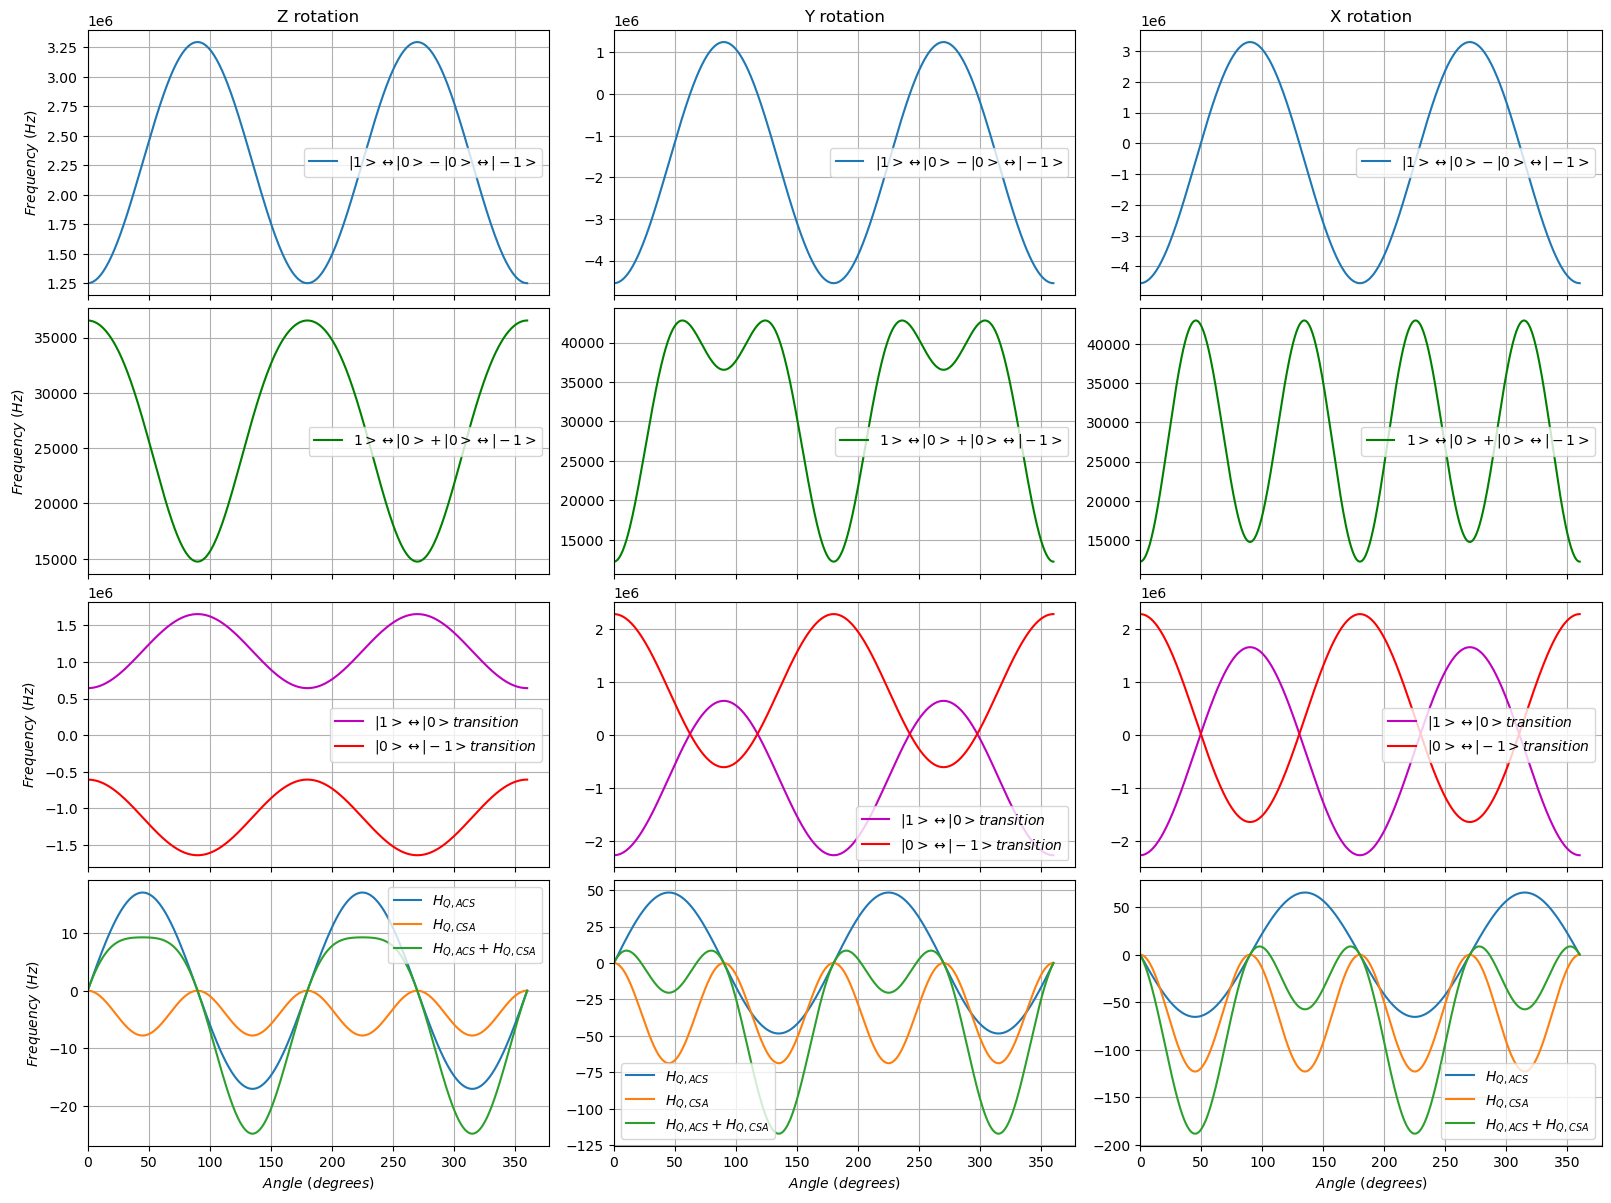

In [3]:
import matplotlib.pyplot as plt

Fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,12), sharex=True,constrained_layout=True)
Fig.suptitle('', fontsize=24) #name of data file read
titles = ['Z rotation', 'Y rotation', 'X rotation']
axes[0,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[1,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[2,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[3,0].set_ylabel(r'$Frequency\ (Hz)$')
for i in range(0,3): #using for loop to plot data for z, y and x
    axes[0,i].plot(x_angle,f_d[i], '-', label = r'$|1>\leftrightarrow|0> - |0>\leftrightarrow|-1>$')
    axes[0,i].set_title(titles[i])
    axes[0,i].set_xlim(left=0)

    axes[0,i].legend(loc='best') 
    axes[0,i].grid()
    axes[1,i].plot(x_angle,f_s[i], '-g', label = r'$1>\leftrightarrow|0> + |0>\leftrightarrow|-1>$')
    
    axes[1,i].legend(loc='best')
    axes[1,i].grid()

    axes[2,i].plot(x_angle,f_1D[i], '-m', label = r'$|1>\leftrightarrow|0> transition$')
    axes[2,i].plot(x_angle,f_2D[i], '-r',label = r'$|0>\leftrightarrow|-1> transition$')
    axes[2,i].legend(loc='best')
    axes[2,i].grid()

    axes[3,i].plot(x_angle, f_acs[i], label = r'$H_{Q, ACS}$')
    axes[3,i].plot(x_angle, f_csa[i], label = r'$H_{Q, CSA}$')
    axes[3,i].plot(x_angle, f_csa[i]+f_acs[i], label = r'$H_{Q, ACS} +H_{Q, CSA} $')
    axes[3,i].set_xlabel(r'$Angle\ (degrees)$')
    axes[3,i].legend(loc='best')
    axes[3,i].grid()

**Defining the Fourier Function**

In [4]:

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
   
    series = a0 + sum(ai * cos(i * f * x*np.pi/180. ) + bi * sin(i * f * x*np.pi/180. ) #converting degrees -> radians
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')

In [5]:
x_float = np.array(x_angle, dtype = float) #change angle to radians

# #input as an array to check if for loop works
# f_s_float = [np.array(f_sx, dtype=float),np.array(f_sy, dtype=float), np.array(f_sz, dtype=float)]#sum frequency
# f_d_float = [np.array(f_dx, dtype = float),np.array(f_dy, dtype=float),  np.array(f_dz, dtype = float)] #difference frequency
#****************************************************

f_s_float = np.array(f_s, dtype=float) #sum frequency
f_d_float = np.array(f_d, dtype = float) #difference frequency

# fy_s_float = np.array(f_sy, dtype=float) #sum frequency
# fy_d_float = np.array(f_dy, dtype=float) #difference frequency

# fz_s_float = np.array(f_sz, dtype=float) #sum frequency
# fz_d_float = np.array(f_dz, dtype = float) #difference frequency

**Fitting Sum frequency**

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        2.664735e+04 7.008965e-12
a1        1.090562e+04 9.902335e-12
a2        -1.003996e+03 9.902335e-12
b1        2.137012e-11 9.922002e-12
b2        -6.849002e-12 9.922002e-12
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   9
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390c94220>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0390c94370>

Goodness of fit qualifiers:
chi_squared            1.2207319721820769e-17
objective_value        6.1036598609103844e-18
r_squared              1.0


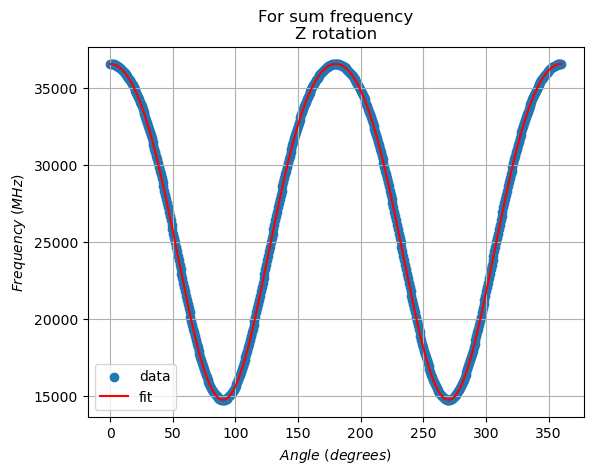

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        3.244700e+04 8.365409e-12
a1        -1.216182e+04 1.181873e-11
a2        -8.059854e+03 1.181873e-11
b1        -1.319117e-11 1.184221e-11
b2        -1.590100e-11 1.184221e-11
Status message         Optimization terminated successfully.
Number of iterations   7
Objective              <symfit.core.objectives.LeastSquares object at 0x7f04446ce320>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f04446cfee0>

Goodness of fit qualifiers:
chi_squared            1.738949045417973e-17
objective_value        8.694745227089865e-18
r_squared              1.0


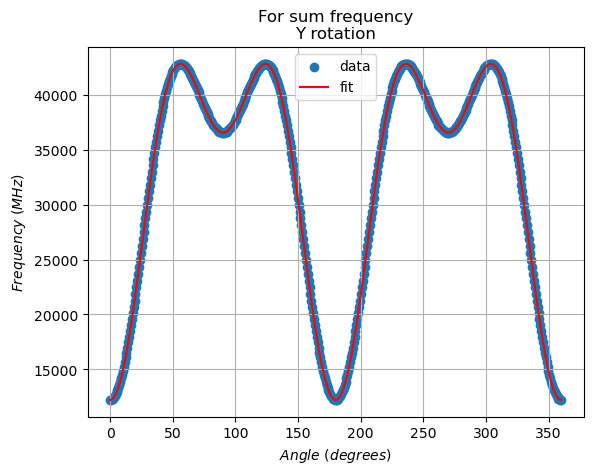

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        2.823469e+04 9.203893e-12
a1        -1.256206e+03 1.300335e-11
a2        -1.475316e+04 1.300335e-11
b1        -4.610071e-12 1.302918e-11
b2        -5.222240e-11 1.302918e-11
Status message         Optimization terminated successfully.
Number of iterations   9
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390bb5ae0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0390bb6080>

Goodness of fit qualifiers:
chi_squared            2.1050171637588253e-17
objective_value        1.0525085818794127e-17
r_squared              1.0


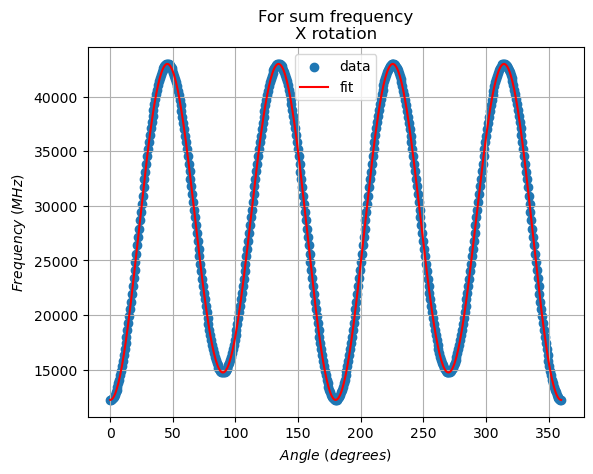

In [6]:
xdata = x_float
ydata = f_s_float

model_dict_s = {y: fourier_series(x, f=2, n=2)}



for i in range(len(titles)):
    fit = Fit(model_dict_s, x=xdata, y=ydata[i])
    fit_result_s = fit.execute()
    print('Fitting Function:',model_dict_s)
    print('Fit result:''\n',fit_result_s)
    plt.scatter(xdata, ydata[i], label = "data")
    plt.plot(xdata, fit.model(xdata, **fit_result_s.params).y,  label = "fit", color = 'red')
    plt.title('For sum frequency\n'+ titles[i])
    plt.xlabel(r'$Angle\ (degrees)$')
    plt.ylabel(r'$Frequency\ (MHz)$')
    plt.grid()
    plt.legend()
    plt.show()

**Fitting Difference Frequency**

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        2.272477e+06 3.706092e-11
a1        -1.022625e+06 5.236004e-11
a2        2.334142e+01 5.236004e-11
b1        1.022625e+02 5.246403e-11
b2        -7.711374e-12 5.246403e-11
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   7
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390a60400>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0390a60520>

Goodness of fit qualifiers:
chi_squared            3.413068438984368e-16
objective_value        1.706534219492184e-16
r_squared              1.0


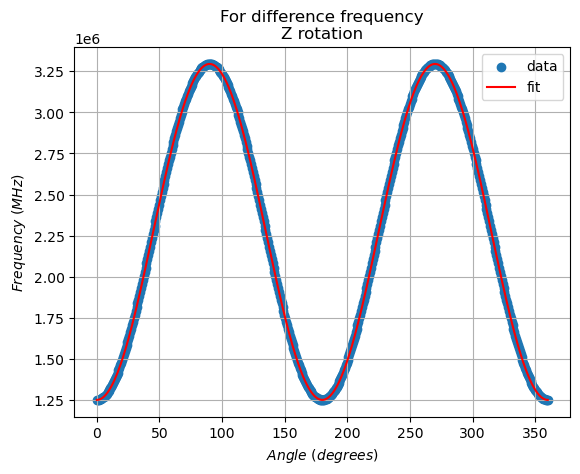

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        -1.647768e+06 8.653972e-11
a1        -2.897437e+06 1.222642e-10
a2        2.059716e+02 1.222642e-10
b1        2.897437e+02 1.225070e-10
b2        1.268827e-11 1.225070e-10
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   12
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390a46c50>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0390a45720>

Goodness of fit qualifiers:
chi_squared            1.8609875010504534e-15
objective_value        9.304937505252267e-16
r_squared              1.0


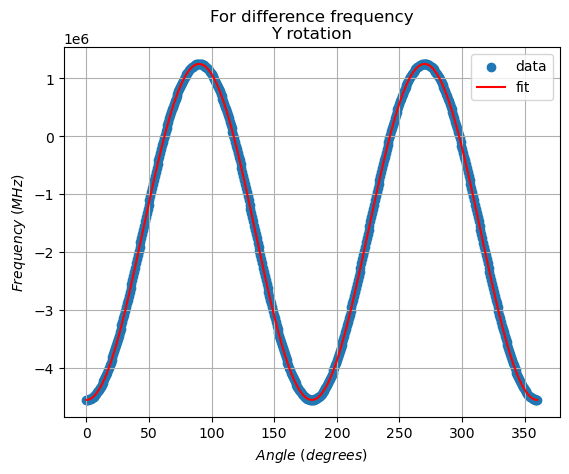

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        -6.253056e+05 1.148326e-10
a1        -3.920062e+06 1.622366e-10
a2        3.681429e+02 1.622366e-10
b1        -3.920063e+02 1.625588e-10
b2        -5.779264e-11 1.625588e-10
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   14
Objective              <symfit.core.objectives.LeastSquares object at 0x7f04446ffe20>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f04446fe020>

Goodness of fit qualifiers:
chi_squared            3.276744517924815e-15
objective_value        1.6383722589624075e-15
r_squared              1.0


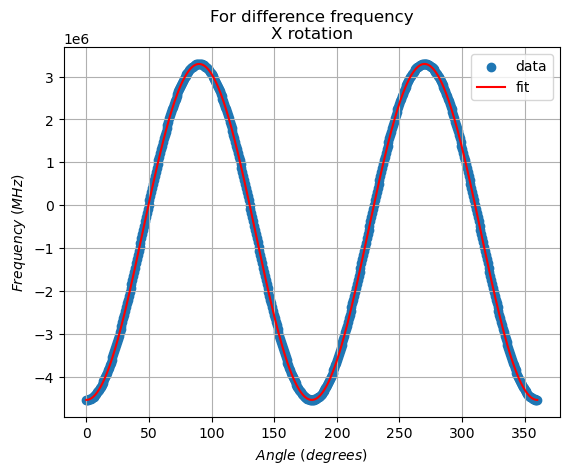

In [7]:
xdata = x_float
ydata = f_d_float
fit_result_d = [0]*3
model_dict_d = {y: fourier_series(x, f=2, n=2)}

for i in range(len(titles)):
    fit = Fit(model_dict_d, x=xdata, y=ydata[i])
    fit_result_d[i] = fit.execute()
    
    print('Fitting Function:',model_dict_d)
    print('Fit result:''\n',fit_result_d[i])
    plt.scatter(xdata, ydata[i], label = "data")
    plt.plot(xdata, fit.model(xdata, **fit_result_d[i].params).y,  label = "fit", color = 'red')
    
    plt.title('For difference frequency\n' +titles[i])
    plt.xlabel(r'$Angle\ (degrees)$')
    plt.ylabel(r'$Frequency\ (MHz)$')
    plt.legend()
    plt.grid()
    plt.show()

**Finding Quadrupolar Tensor**

In [8]:

# fit = [0]*3

A = [0]*3
B = [0]*3
C = [0]*3
A_HQ1 = [0]*3
B_HQ1 = [0]*3
X = [0]*3


for i in range(0,3):
    A[i] = fit_result_d[i].params['a0']
    B[i] = fit_result_d[i].params['a1']
    C[i]= fit_result_d[i].params['b1']
    A_HQ1[i] = np.array([[1, 1], [1, -1]])
    B_HQ1[i] = np.array([A[i], B[i]])
    X[i] = np.linalg.inv(A_HQ1[i]).dot(B_HQ1[i])
    
    print(X[i])
gxx_q = X[0][0]
gyy_q= X[0][1]
gxy_q = -C[0]/2

gzz_q = X[1][0]
gxz_q = C[1]/2

gyz_q = -C[2]/2


y = [gzz_q, gyy_q, gyz_q, gxx_q, gxz_q, gxy_q]
print(y)
A = [gzz_q + gyy_q, gzz_q + gxx_q, gxx_q + gyy_q]
B = [gzz_q - gyy_q, gzz_q - gxx_q, gxx_q - gyy_q ]
C = [-2*gyz_q, 2*gxz_q, -2*gxy_q]

HQ1= [0]*3

for i in range(3):
   HQ1[i] = A[i] + B[i]*np.cos(2*x_angle*np.pi/180.) + C[i]*np.cos(2*x_angle*np.pi/180.) 

[ 624925.82929219 1647550.82929219]
[-2272602.98579414   624834.51420586]
[-2272684.07143476  1647378.42856523]
[-2272602.9857941396, 1647550.829292187, 196.0031250027414, 624925.8292921875, 144.87187499797238, -51.13124999930137]


In [9]:
A = [0]*3
B = [0]*3
C = [0]*3
D = [0]*3
E = [0]*3

# x coefficients
A[2] = (9/64*(gzz_q + gyy_q)**2 + 9/128*(gyy_q-gzz_q)**2 + 5/32*gyz_q**2 + 1/4*gxz_q**2 + 1/4*gxy_q**2)
B[2] = 3/32*(gyy_q**2 - gzz_q**2)
C[2] = 3/16*(gzz_q + gyy_q)*gyz_q
D[2] = 3/32*(gyz_q**2 - 1/4*(gzz_q - gyy_q)**2)
E[2] = 3/32*((gzz_q - gyy_q)*gyz_q)

#y coefficients
A[1] = (9/64*(gzz_q + gxx_q)**2 + 9/128*(gxx_q-gzz_q)**2 + 5/32*gxz_q**2 + 1/4*gyz_q**2 + 1/4*gxy_q**2)
B[1] = 3/32*(gxx_q**2 - gzz_q**2)
C[1] = -3/16*(gzz_q + gxx_q)*gxz_q
D[1] = 3/32*(gxz_q**2 - 1/4*(gzz_q - gxx_q)**2)
E[1] = 3/32*((gxx_q - gzz_q)*gxz_q)

#z coefficients
A[0] = (9/64*(gyy_q + gxx_q)**2 + 9/128*(gxx_q-gyy_q)**2 + 5/32*gxy_q**2 + 1/4*gxz_q**2 + 1/4*gyz_q**2)
B[0] = 3/32*(gyy_q**2 - gxx_q**2)
C[0] = 3/16*(gyy_q + gxx_q)*gxy_q
D[0] = 3/32*(gxy_q**2 - 1/4*(gyy_q - gxx_q)**2)
E[0] = 3/32*((gxx_q - gyy_q)*gxy_q)


In [10]:
HQ2 = [0]*3
for i in range(0,3):
    HQ2[i] = A[i] + B[i]*np.cos(2*x_angle*np.pi/180.) + C[i]*np.sin(2*x_angle*np.pi/180.) + D[i]*np.cos(4*x_angle*np.pi/180.) + E[i]*np.sin(4*x_angle*np.pi/180.)



In [11]:
def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
   
    series = a0 + sum(ai * cos(i * f * x*np.pi/180. ) + bi * sin(i * f * x*np.pi/180. ) #converting degrees -> radians
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        -7.997387e+11 8.235408e-06
a1        -2.178648e+11 1.163507e-05
a2        2.451004e+10 1.163507e-05
b1        2.178648e+07 1.165817e-05
b2        -4.902009e+06 1.165817e-05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   11
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390a60610>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0390a63040>

Goodness of fit qualifiers:
chi_squared            1.68532133102417e-05
objective_value        8.42660665512085e-06
r_squared              1.0


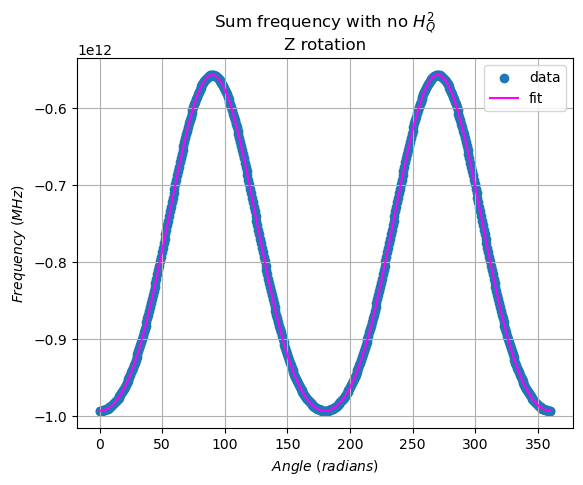

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        -9.720951e+11 1.962368e-05
a1        4.475805e+11 2.772453e-05
a2        1.967736e+11 2.772453e-05
b1        -4.475664e+07 2.777960e-05
b2        -3.935348e+07 2.777960e-05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   8
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390bb5d50>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0392e0f6a0>

Goodness of fit qualifiers:
chi_squared            9.569153189659119e-05
objective_value        4.784576594829559e-05
r_squared              1.0


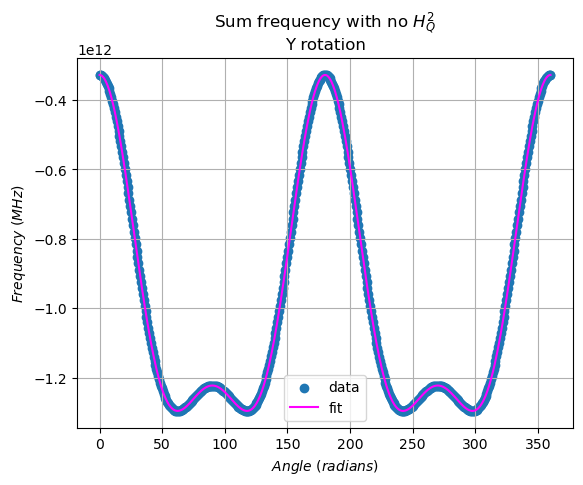

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        -1.135476e+12 2.388713e-05
a1        2.297157e+11 3.374797e-05
a2        3.601782e+11 3.374797e-05
b1        2.297103e+07 3.381499e-05
b2        7.203397e+07 3.381499e-05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   11
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0390aebfd0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0392e0cd60>

Goodness of fit qualifiers:
chi_squared            0.0001417882740497589
objective_value        7.089413702487946e-05
r_squared              1.0


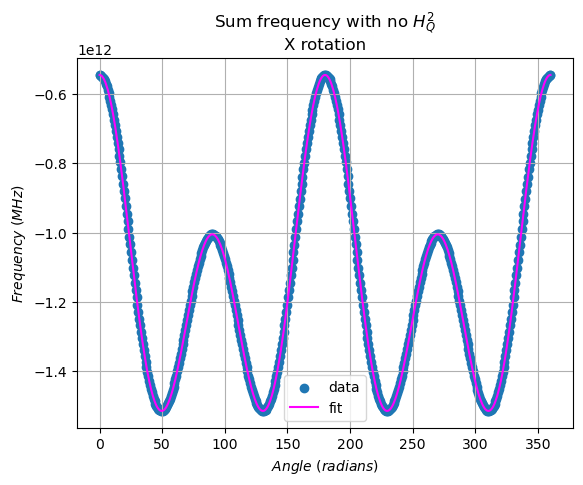

In [12]:
xdata = x_float
f_csa = [0]*3
fit_result_csa = [0]*3

model_dict_csa = {y: fourier_series(x, f=2, n=2)}

for i in range(len(titles)):
    f_csa[i] = np.array((f_s[i] - HQ2[i]), dtype = float)

    # Define a Fit object for this model and data
    fit = Fit(model_dict_csa, x=xdata, y=f_csa[i])
    fit_result_csa[i] = fit.execute()
    print('Fitting Function:',model_dict_csa)
    print('Fit result:''\n',fit_result_csa[i])

    # Plot the result
    plt.scatter(xdata, f_csa[i], label = "data")
    plt.plot(xdata, fit.model(xdata, **fit_result_csa[i].params).y, label = "fit", color = 'magenta')
    plt.title(r'Sum frequency with no $H_Q^2$'+'\n'+titles[i])
    plt.xlabel(r'$Angle\ (radians)$')
    plt.ylabel(r'$Frequency\ (MHz)$')
    plt.legend()
    plt.grid()
    plt.show()


In [13]:
A = [0]*3
B = [0]*3
C = [0]*3
A_HCSA1 = [0]*3
B_HCSA1 = [0]*3
X = [0]*3


for i in range(0,3):
    A[i] = fit_result_csa[i].params['a0']
    B[i] = fit_result_csa[i].params['a1']
    C[i]= fit_result_csa[i].params['b1']
    A_HCSA1[i] = np.array([[1, 1], [1, -1]])
    B_HCSA1[i] = np.array([A[i], B[i]])
    X[i] = np.linalg.inv(A_HCSA1[i]).dot(B_HCSA1[i])
    
    print(X[i])

gxx_csa = X[0][0]
gyy_csa= X[0][1]
gxy_csa = -C[0]/2

gzz_csa = X[1][0]
gxz_csa = C[1]/2

gyz_csa = -C[2]/2

[-5.08801775e+11 -2.90936963e+11]
[-2.62257320e+11 -7.09837812e+11]
[-4.52879953e+11 -6.82595632e+11]


In [14]:
from tabulate import tabulate
print(tabulate([['gxx_q',gxx_q], ['gyy_q',gyy_q], ['gzz_q',gzz_q], ['gxy_q',gxy_q], ['gyz_q',gyz_q], ['gxz_q',gxz_q],['gxx_csa',gxx_csa], ['gyy_csa',gyy_csa], ['gzz_csa',gzz_csa], ['gxy_csa',gxy_csa], ['gyz_csa',gyz_csa], ['gxz_csa',gxz_csa]]))

-------  ----------------
gxx_q    624926
gyy_q         1.64755e+06
gzz_q        -2.2726e+06
gxy_q       -51.1312
gyz_q       196.003
gxz_q       144.872
gxx_csa      -5.08802e+11
gyy_csa      -2.90937e+11
gzz_csa      -2.62257e+11
gxy_csa      -1.08932e+07
gyz_csa      -1.14855e+07
gxz_csa      -2.23783e+07
-------  ----------------


In [15]:
#****** Input Vaue****************
#coupling values for NAV (taken from paper https://pubmed.ncbi.nlm.nih.gov/22027340/)


#for CSA
delta_fit = gzz_csa/w0
eta_fit = (gxx_csa- gyy_csa)/gzz_csa

#for Quadrupolar
CQ_fit = gzz_q*(2*Ispin*(2*Ispin - 1))/10**6
Qeta_fit = (gxx_q - gyy_q)/gzz_q

table = [['delta', delta_fit, delta_ppm, abs(delta_fit - delta_ppm)*100/delta_ppm],  ['eta', eta_fit, eta, abs(eta_fit - eta)*100/eta], ['CQ', CQ_fit, CQ_M, abs((CQ_fit - CQ_M)/CQ_M)*100], ['Qeta', Qeta_fit ,Qeta, abs(Qeta_fit - Qeta)*100/Qeta]]
print(tabulate(table, headers=['Qauntity', 'Fit Value','Input Value', '% difference']))

Qauntity      Fit Value    Input Value    % difference
----------  -----------  -------------  --------------
delta       -6.0428e+09        110         5.49345e+09
eta          0.830729            0.415   100.176
CQ          -4.54521            -3.03     50.0068
Qeta         0.44998             0.45      0.00453162


In [16]:
A[2] = 3/2*(gxz_q*gxz_csa + gxy_q*gxy_csa - gyz_q*gyz_csa - 1/4*(gyy_q - gzz_q)*(gyy_csa - gzz_csa))
B[2] = 3/2*(gxz_q*gxz_csa - gxy_q*gxy_csa)
C[2] = -3/2*(gxy_q*gxz_csa + gxz_q*gxy_csa)
D[2] = 3/2*(1/4*(gyy_q - gzz_q)*(gyy_csa - gzz_csa) - gyz_q*gyz_csa)
E[2] = 3/4*((gyy_q - gzz_q)*gyz_csa - gyz_q*(gyy_csa - gzz_csa))

A[1] = 3/2*(gxz_q*gxz_csa + gxy_q*gxy_csa + gyz_q*gyz_csa + 1/4*(gzz_q - gxx_q)*(gzz_csa - gxx_csa))
B[1] = 3/2*(gyz_q*gyz_csa - gxy_q*gxy_csa)
C[1] = 3/2*(gxy_q*gyz_csa + gyz_q*gxy_csa)
D[1] = 3/2*(gxz_q*gxz_csa - 1/4*(gzz_q - gxx_q)*(gzz_csa - gxx_csa))
E[1] = 3/4*((gxx_q - gzz_q)*gxz_csa + gxz_q*(gxx_csa - gzz_csa))

A[0] = 3/2*(gxz_q*gxz_csa + gxy_q*gxy_csa + gyz_q*gyz_csa + 1/4*(gxx_q - gyy_q)*(gxx_csa - gyy_csa))
B[0] = 3/2*(gxz_q*gxz_csa - gyz_q*gyz_csa)
C[0] = -3/2*(gyz_q*gxz_csa + gxz_q*gyz_csa)
D[0] = 3/2*(gxy_q*gxy_csa - 1/4*(gxx_q - gyy_q)*(gxx_csa - gyy_csa))
E[0] = 3/4*((gxx_q - gyy_q)*gxy_csa + gxy_q*(gxx_csa - gyy_csa))

H_QCSA = [0]*3
for i in range(0,3):
    H_QCSA[i] = A[i] + B[i]*np.cos(2*x_angle*np.pi/180.) + C[i]*np.sin(2*x_angle*np.pi/180.) + D[i]*np.cos(4*x_angle*np.pi/180.) + E[i]*np.sin(4*x_angle*np.pi/180.)

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        1.000000e+00 4.602186e+15
a1        1.000000e+00 6.502014e+15
a2        1.000000e+00 6.502014e+15
b1        1.000000e+00 6.514928e+15
b2        1.000000e+00 6.514928e+15
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   0
Objective              <symfit.core.objectives.LeastSquares object at 0x7f039370da50>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f039370dc30>

Goodness of fit qualifiers:
chi_squared            5.2630909770237387e+36
objective_value        2.6315454885118693e+36
r_squared              -2.0040080234377724


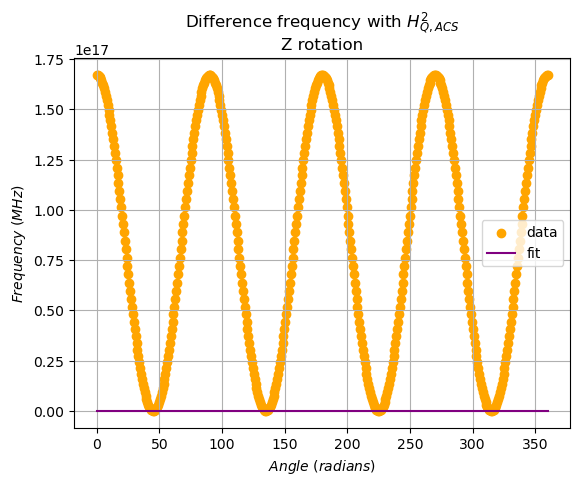

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        1.000000e+00 1.475651e+16
a1        1.000000e+00 2.084814e+16
a2        1.000000e+00 2.084814e+16
b1        1.000000e+00 2.088955e+16
b2        1.000000e+00 2.088955e+16
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   0
Objective              <symfit.core.objectives.LeastSquares object at 0x7f0393722890>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f0393723040>

Goodness of fit qualifiers:
chi_squared            5.4110292393964135e+37
objective_value        2.7055146196982068e+37
r_squared              -2.0040080020368665


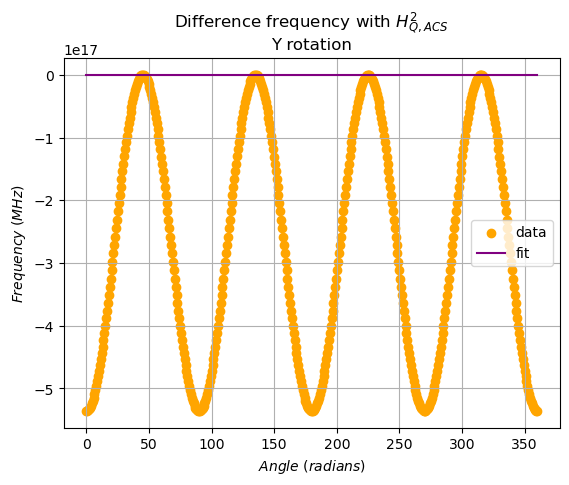

Fitting Function: {y: a0 + a1*cos(0.0349065850398866*x) + a2*cos(0.0698131700797732*x) + b1*sin(0.0349065850398866*x) + b2*sin(0.0698131700797732*x)}
Fit result:
 
Parameter Value        Standard Deviation
a0        1.000000e+00 2.316234e+15
a1        1.000000e+00 3.272399e+15
a2        1.000000e+00 3.272399e+15
b1        1.000000e+00 3.278898e+15
b2        1.000000e+00 3.278898e+15
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   0
Objective              <symfit.core.objectives.LeastSquares object at 0x7f03909b71f0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f03909b6f80>

Goodness of fit qualifiers:
chi_squared            1.333145446223831e+36
objective_value        6.665727231119155e+35
r_squared              -1.9880708523188138


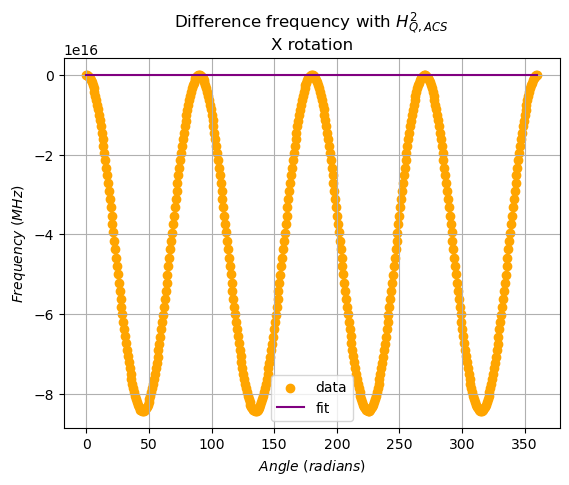

In [17]:
xdata = x_float
f_acs = [0]*3
fit_result_acs = [0]*3

model_dict_acs = {y: fourier_series(x, f=2, n=2)}

for i in range(len(titles)):
    f_acs[i] = np.array((f_d[i] - (HQ1[i] + H_QCSA[i])), dtype = float)

    # Define a Fit object for this model and data
    fit = Fit(model_dict_acs, x=xdata, y=f_acs[i])
    fit_result_acs[i] = fit.execute()
    print('Fitting Function:',model_dict_acs)
    print('Fit result:''\n',fit_result_acs[i])

    # Plot the result
    plt.scatter(xdata, f_acs[i], label = "data", color = 'orange')
    plt.plot(xdata, fit.model(xdata, **fit_result_acs[i].params).y, label = "fit", color = 'purple')
    plt.title(r'Difference frequency with $H_{Q, ACS}^2$'+'\n'+titles[i])
    plt.xlabel(r'$Angle\ (radians)$')
    plt.ylabel(r'$Frequency\ (MHz)$')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
import numpy as np
A = [0]*3   #A coefficient for HQ,ACS
B = [0]*3   #B coefficient for HQ,ACS
C = [0]*3   #C coefficient for HQ,ACS
A_QACS = [0]*3 #coefficients for variables
B_QACS = [0]*3
X = [0]*3

A_QACS[0] = np.array([[3/2*-gxz_q, 3/2*-gyz_q, 0], [3/2*-gxz_q, 3/2*gyz_q, 3/2*-2*gxy_q], [3/2*gyz_q, 3/2*gxy_q, 3/2*(gyy_q - gxx_q)]]) 
A_QACS[1] = np.array([[3/2*gxy_q, 3/2*-gyz_q, 0], [3/2*-gxy_q, 3/2*-gyz_q, 3/2*+2*gxz_q], [3/2*gxy_q, 3/2*-gyz_q, 3/2*-(gzz_q - gxx_q)]]) 
A_QACS[2] = np.array([[3/2*-gxy_q, 3/2*-gxz_q, 0], [3/2*gxy_q, 3/2*-gxz_q, 3/2*-2*gyz_q], [3/2*gxz_q, 3/2*gxy_q, 3/2*(gyy_q - gzz_q)]]) 



for i in range(0,3):
    A[i] = fit_result_acs[i].params['a0']
    B[i] = fit_result_acs[i].params['a1']
    C[i]= fit_result_acs[i].params['b1']
    B_QACS[i] = np.array([A[i], B[i], C[i]])
    X[i] = np.linalg.solve(A_QACS[i],B_QACS[i]) 
print(X)
gxz_acs = X[0][0]
gyz_acs = X[0][1]
gxy_acs = X[0][2]

gxy_acs = X[1][0]
# | 2x-4y+4z=8  |
# | 34x+3y-z=30 |
# | x+y+z=108   |

# a = np.array([[2, -4, 4], [34, 3, -1], [1, 1, 1]])
# b = np.array([8, 30, 108])
# x = np.linalg.solve(a, b)
# print (x) # [ -2.17647059  53.54411765  56.63235294]

[array([-4.60122603e-03, -4.00121398e-07,  1.53379869e-06]), array([-4.96944968e-20, -3.40130631e-03,  0.00000000e+00]), array([-4.21871168e-07, -4.60191626e-03,  1.10053348e-07])]


In [19]:
X[0][0]

-0.004601226025628548

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


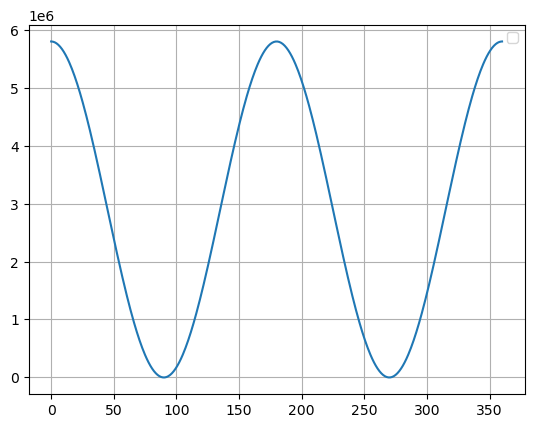

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


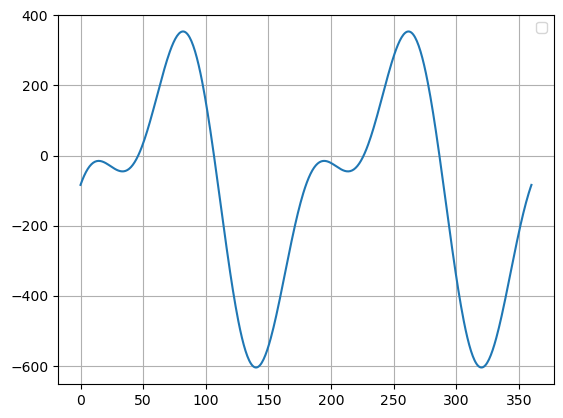

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


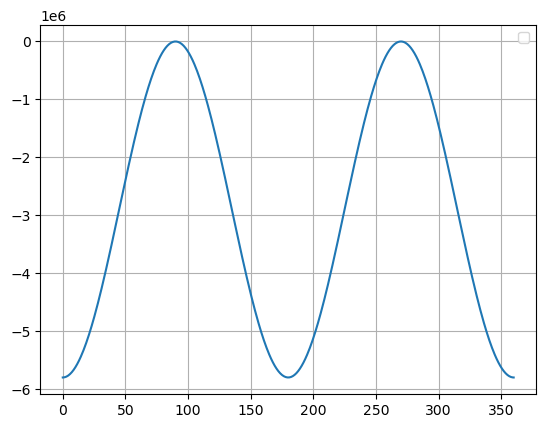

In [20]:
f_Ql = [0]*3
for i in range(0,3):
  f_Ql[i] = f_d[i] - HQ1[i]
  plt.plot(XX, f_Ql[i])  
  plt.legend()
  plt.grid()
  plt.show()